In [1]:
import configparser
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

inifile = configparser.ConfigParser()
inifile.read('../config.ini')
df = pd.read_csv(
    inifile.get('url', 'breast_cancer_wisconsin'), header=None)
X = df.loc[:, 2:].values
y = df.loc[:, 1].values
le = LabelEncoder()
y = le.fit_transform(y)
le.transform(['M', 'B'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)
pipe_svc = Pipeline(
    [('scl', StandardScaler()), ('clf', SVC(random_state=0))])
pipe_svc.fit(X_train, y_train)
y_pred = pipe_svc.predict(X_test)

In [2]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score, f1_score
print('Precision: %.3f' %(precision_score(y_true=y_test, y_pred=y_pred)))
print('Recall: %.3f' %(recall_score(y_true=y_test, y_pred=y_pred)))
print('F1: %.3f' %(f1_score(y_true=y_test, y_pred=y_pred)))

Precision: 0.976
Recall: 0.952
F1: 0.964


In [3]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
# 0を陽性ラベルにする
scorer = make_scorer(f1_score, pos_label=0)
c_gamma_range = [0.01, 0.1, 1.0, 10.0]
param_grid = [
    {'clf__C': c_gamma_range, 'clf__kernel': ['linear']},
    {'clf__C': c_gamma_range, 'clf__gamma': c_gamma_range, 'clf__kernel': ['rbf']}
]
gs = GridSearchCV(estimator=pipe_svc, param_grid=param_grid, scoring=scorer, cv=10, n_jobs=-1)
gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.982798668208
{'clf__kernel': 'linear', 'clf__C': 0.1}


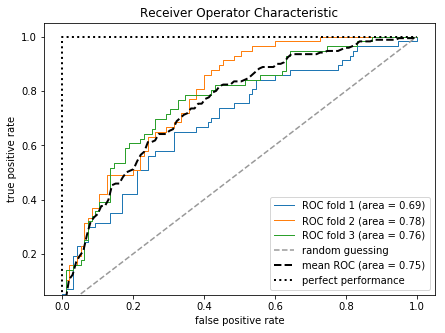

In [4]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from scipy import interp
pipe_lr = Pipeline([
    ('scl', StandardScaler()),
    ('pca', PCA(n_components=2)),
    ('clf', LogisticRegression(penalty='l2', random_state=0, C=100.0))
])
X_train2 = X_train[:, [4, 14]]
cv = list(StratifiedKFold(n_splits=3, random_state=1).split(X_train, y_train))
fig = plt.figure(figsize=(7, 5))
mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []
for i, (train, test) in enumerate(cv):
    probas = pipe_lr.fit(X_train2[train], y_train[train]).predict_proba(X_train2[test])
    fpr, tpr, thresholds = roc_curve(y_train[test], probas[:, 1], pos_label=1)
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' %(i+1, roc_auc))
# 当て推量をプロット
plt.plot([0, 1], [0, 1], linestyle='--', color=(0.6, 0.6, 0.6), label='random guessing')
mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
# ここでsyntax_errorc
plt.plot(mean_fpr, mean_tpr, 'k--', label='mean ROC (area = %0.2f)' %(mean_auc), lw=2)
plt.plot([0, 0, 1], [0, 1, 1], lw=2, linestyle=':', color='black', label='perfect performance')
plt.xlim([-0.05, 1.05])
plt.ylim([0.05, 1.05])
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('Receiver Operator Characteristic')
plt.legend(loc='lower right')
plt.show()

In [5]:
pipe_lr = pipe_lr.fit(X_train2, y_train)
y_pred2 = pipe_lr.predict(X_test[:, [4, 14]])
from sklearn.metrics import roc_auc_score, accuracy_score
print('ROC AUC: %.3f' %(roc_auc_score(y_true=y_test, y_score=y_pred2)))
print('Accuracy: %.3f' %(accuracy_score(y_true=y_test, y_pred=y_pred2)))

ROC AUC: 0.662
Accuracy: 0.711


In [6]:
# デフォルトではマクロ平均が適用されるが、averageを指定することでミクロ平均も適用ができる
pre_scorer = make_scorer(score_func=precision_score, 
                         pos_label=1, 
                         greater_is_better=True, 
                         average='micro')